In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from math import log
import matplotlib.pyplot as plt

In [2]:
from src.data_loader import get_combined_data, data_preprocessing

In [ ]:
df = get_combined_data()
df_africa = data_preprocessing(df, dyad_id = False)

df_africa = df_africa[(df_africa['actor1'] != 'Civilians') & (df_africa['actor2'] != 'Civilians')]
df_africa.head()

/Users/sarahdeubner/PythonProjects/Consulting/Consulting-Conflict-Sequences-Africa/src/data_loader.py:82: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  ucdp_df = pd.read_csv(ucdp_path)


,event_id_cnty,event_date,year,time_precision,disorder_type,actor1,actor2,actor1_id,actor2_id,latitude,...,region,geo_precision,fatalities,notes,source,source_dataset,time_precision_text,month,month_year,dyad
0,DRC31402,2023-12-31 00:00:00,2023,1,Political violence,Rioters (Democratic Republic of Congo),Rioters (Democratic Republic of Congo),Rioters (Democratic Republic of Congo),NaN,-6.1500,...,Middle Africa,1,0,"On 31 December 2023, rioters burnt and ransack...",7 Sur 7; Election-Net; Radio Okapi; Twitter,ACLED,day,12,2023-12-01,Rioters (Democratic Republic of Congo):Rioters...
1,BFO11325,2023-12-31 00:00:00,2023,1,Political violence,JNIM: Group for Support of Islam and Muslims,JNIM: Group for Support of Islam and Muslims,JNIM: Group for Support of Islam and Muslims,NaN,12.9871,...,Western Africa,1,0,"On 31 December 2023, a cattle hit an IED likel...",Facebook,ACLED,day,12,2023-12-01,JNIM: Group for Support of Islam and Muslims:J...
2,BFO11326,2023-12-31 00:00:00,2023,1,Political violence,JNIM: Group for Support of Islam and Muslims,Military Forces of Burkina Faso (2022-),JNIM: Group for Support of Islam and Muslims,Military Forces of Burkina Faso (2022-),13.4417,...,Western Africa,1,0,"On 31 December 2023, suspected JNIM militants ...",Whatsapp,ACLED,day,12,2023-12-01,JNIM: Group for Support of Islam and Muslims:M...
3,GAB472,2023-12-31 00:00:00,2023,2,Demonstrations,Protesters (Gabon),Protesters (Gabon),Protesters (Gabon),NaN,0.3901,...,Middle Africa,1,0,"Around 31 December 2023 (as reported), ex-work...",Gabon Actu,ACLED,week,12,2023-12-01,Protesters (Gabon):Protesters (Gabon)
4,GHA2083,2023-12-31 00:00:00,2023,2,Political violence,Rioters (Ghana),Rioters (Ghana),Rioters (Ghana),NaN,7.7254,...,Western Africa,1,0,"Around 31 December 2023 (as reported), youths ...",Ghana Web,ACLED,week,12,2023-12-01,Rioters (Ghana):Rioters (Ghana)


In [4]:
df_africa.columns

Index(['event_id_cnty', 'event_date', 'year', 'time_precision',
       'disorder_type', 'actor1', 'actor2', 'actor1_id', 'actor2_id',
       'latitude', 'longitude', 'admin1', 'admin2', 'location', 'country',
       'region', 'geo_precision', 'fatalities', 'notes', 'source',
       'source_dataset', 'time_precision_text', 'month', 'month_year', 'dyad'],
      dtype='object')

### Calculate Edge Length and Type and build Graph

In [5]:
from math import log

# Create a 'year_str' column
df_africa['year_str'] = df_africa['year'].astype(str)
unique_years = df_africa['year_str'].unique()

yearly_graphs = {}

for year in unique_years:
    year_df = df_africa[(df_africa['year_str'] == year) & (df_africa['fatalities'] != 0)]

    yearly_fatalities = year_df.groupby("dyad")["fatalities"].mean().reset_index()

    # Compute edge attributes for this year
    def compute_attributes(fat):
        return {"length": 1 / log(1 + fat), "type": "normal"}

    yearly_fatalities = yearly_fatalities.assign(
        **yearly_fatalities["fatalities"].apply(compute_attributes).apply(pd.Series)
    )

    edge_attr_lookup = yearly_fatalities.set_index("dyad")[["fatalities", "length", "type"]].to_dict("index")

    # Build graph
    G = nx.Graph()
    for _, row in year_df.iterrows():
        actor1, actor2 = row["actor1"], row["actor2"]
        dyad = row["dyad"]

        base_attr = edge_attr_lookup.get(dyad, {"length": 9999, "type": "missing", "fatalities": 0})
        edge_data = {
            "weight": base_attr["length"],
            "type": base_attr["type"],
            "avg_monthly_fatalities": base_attr["fatalities"],  # You may want to rename this if it's yearly
            "disorder_type": row["disorder_type"],
            "latitude": row["latitude"],
            "longitude": row["longitude"],
            "location": row["location"],
            "country": row["country"]
        }

        G.add_edge(actor1, actor2, **edge_data)

    yearly_graphs[year] = G


### Print Example Summary

In [6]:
example_year= '2020'

In [9]:
print(f"Total nodes: {yearly_graphs[example_year].number_of_nodes()}")
print(f"Total edges: {yearly_graphs[example_year].number_of_edges()}")
print("Sample edge with attributes:")
sample_edge = next(iter(yearly_graphs[example_year].edges(data=True)))
print(sample_edge)

Total nodes: 1364
Total edges: 1916
Sample edge with attributes:
('Al-Shabaab', 'Civilians (Somalia)', {'weight': 0.978807594485609, 'type': 'normal', 'avg_monthly_fatalities': 1.7777777777777777, 'disorder_type': 'Political violence', 'latitude': 4.0601, 'longitude': 45.2577, 'location': 'Buqda Caqable', 'country': 'Somalia'})


### Plot Example Network

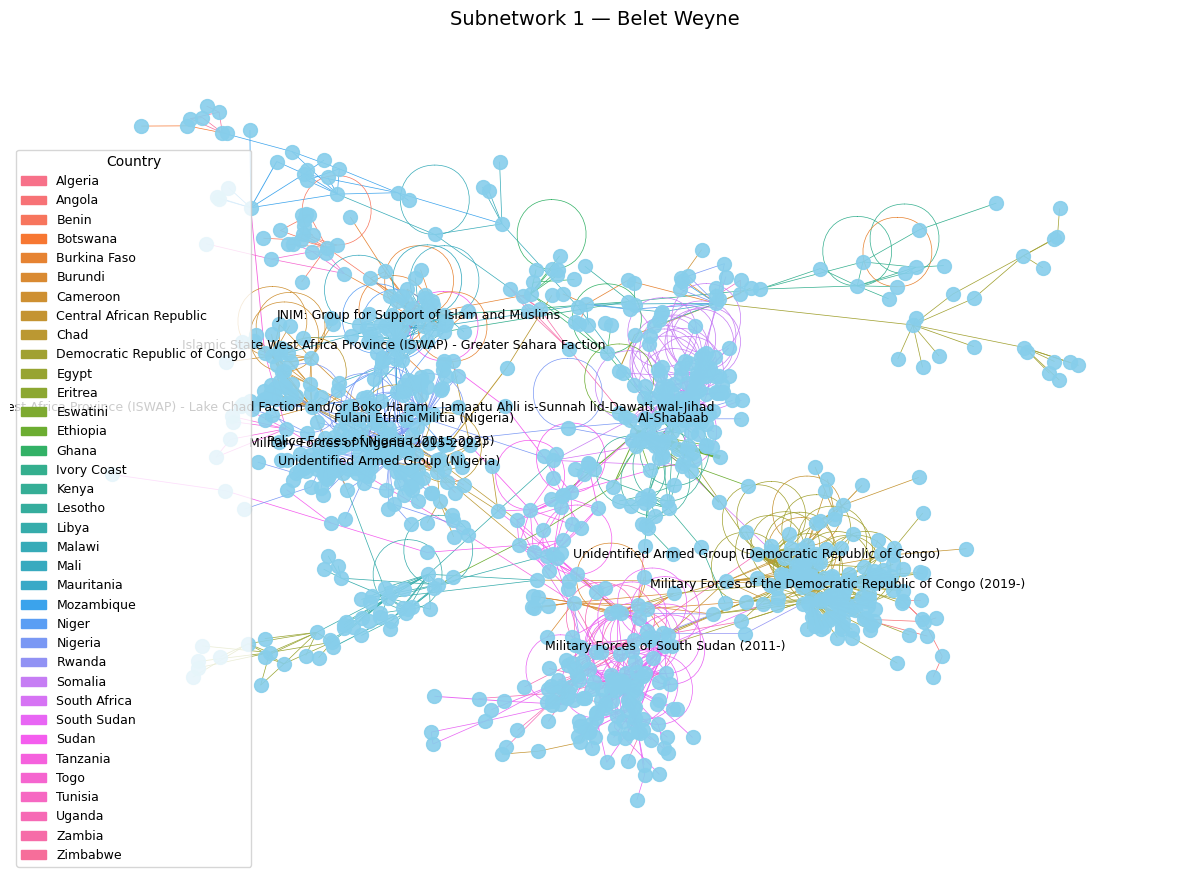

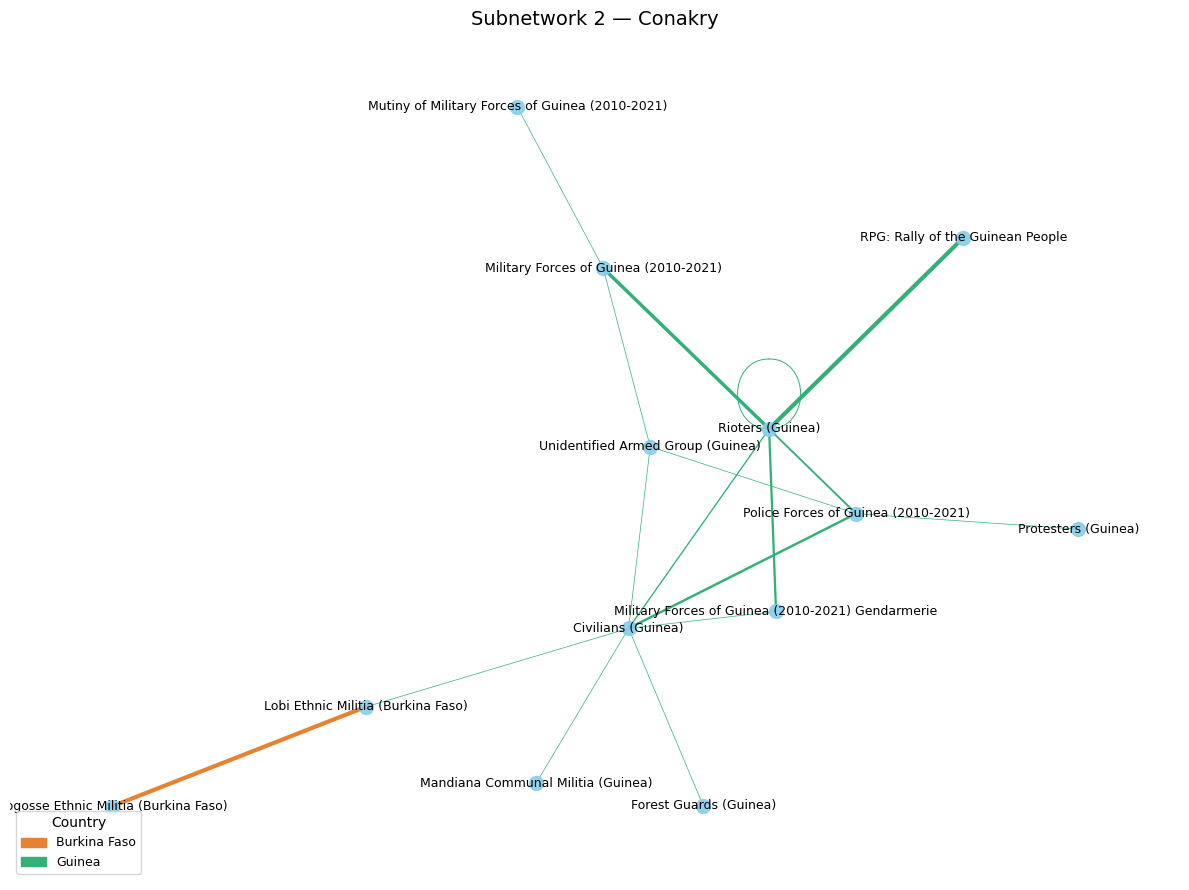

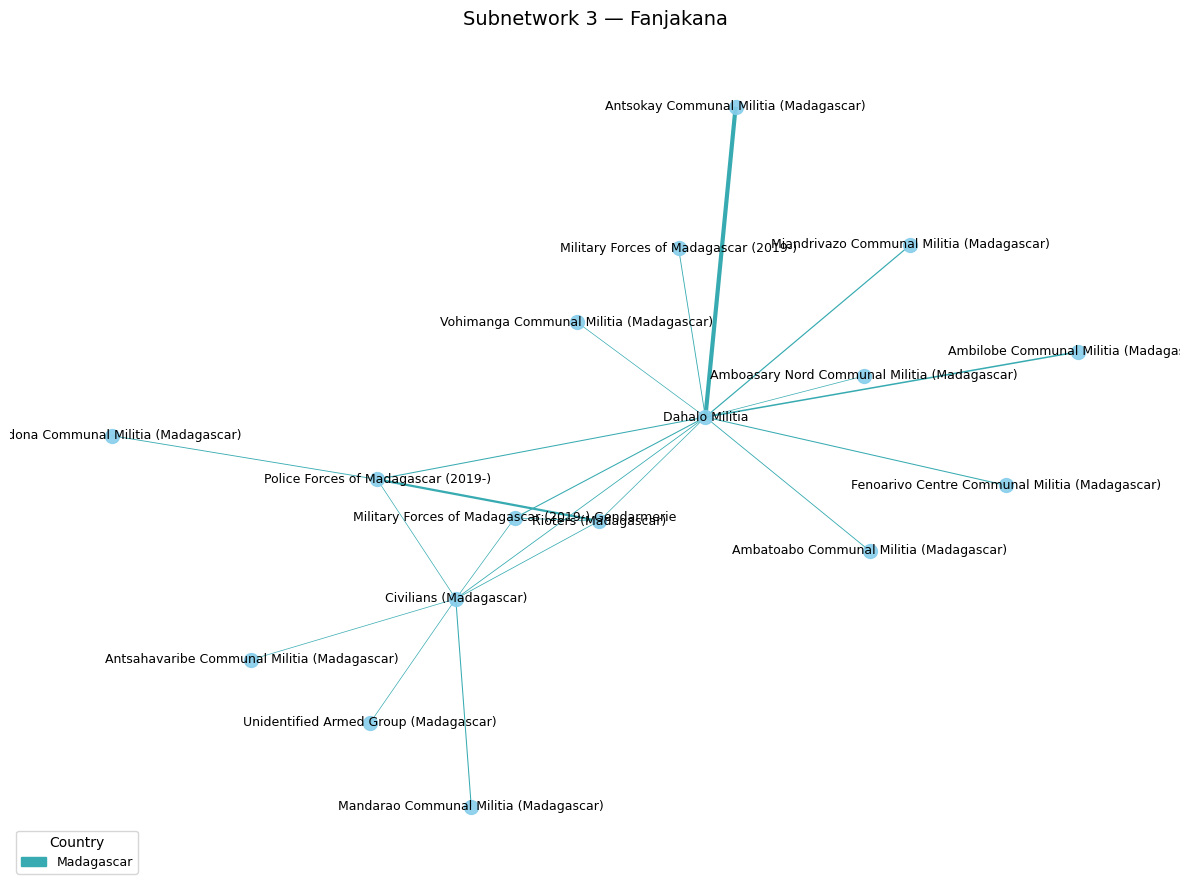

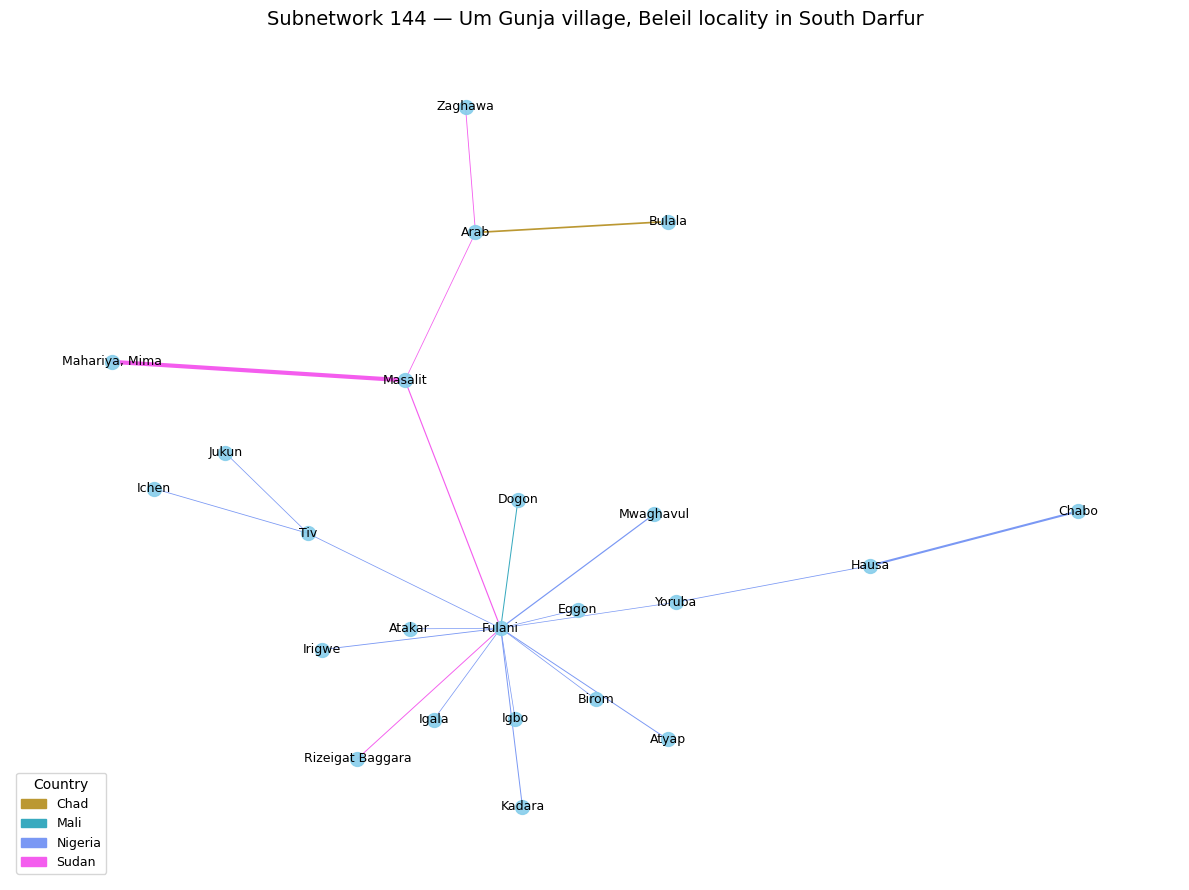

In [11]:
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import networkx as nx

G = yearly_graphs[example_year]
components = list(nx.connected_components(G))

# Build full color map once for consistency
all_countries = {
    d.get('country')
    for _, _, d in G.edges(data=True)
    if d.get('country') is not None
}
country_list = sorted(all_countries)
color_palette = sns.color_palette("husl", len(country_list))
country_color_map = dict(zip(country_list, color_palette))

for i, comp in enumerate(components, start=1):
    if len(comp) <= 8:
        continue

    subgraph = G.subgraph(comp)
    pos = nx.spring_layout(subgraph, weight='weight', seed=42)

    # Normalize edge widths by avg_monthly_fatalities
    fatalities = [d.get('avg_monthly_fatalities', 1) for _, _, d in subgraph.edges(data=True)]
    min_width, max_width = 0.5, 3.0
    min_fat, max_fat = min(fatalities), max(fatalities)

    def normalize_width(fat):
        if max_fat == min_fat:
            return (min_width + max_width) / 2
        return min_width + (fat - min_fat) / (max_fat - min_fat) * (max_width - min_width)

    edge_widths = [normalize_width(f) for f in fatalities]
    edge_colors = [
        country_color_map.get(d.get('country'), (0.5, 0.5, 0.5))
        for _, _, d in subgraph.edges(data=True)
    ]

    # Title from most common location
    locations = [d.get('location') for _, _, d in subgraph.edges(data=True) if d.get('location')]
    title_location = Counter(locations).most_common(1)[0][0] if locations else "Unknown"

    # Subgraph countries for legend
    sub_countries = {
        d.get('country')
        for _, _, d in subgraph.edges(data=True)
        if d.get('country') in country_color_map
    }
    legend_handles = [
        mpatches.Patch(color=country_color_map[country], label=country)
        for country in sorted(sub_countries)
    ]

    # Decide which nodes to label
    if len(subgraph.nodes) > 50:
        labels = {
            node: node
            for node in subgraph.nodes
            if subgraph.degree(node) > 17 and 'civilian' not in node.lower()
        }
    else:
        labels = {node: node for node in subgraph.nodes}

    # Draw
    plt.figure(figsize=(12, 9))
    nx.draw_networkx_nodes(subgraph, pos, node_size=100, node_color='skyblue', alpha=0.9)
    nx.draw_networkx_edges(subgraph, pos, edge_color=edge_colors, width=edge_widths)
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=9)

    plt.title(f"Subnetwork {i} — {title_location}", fontsize=14)
    plt.axis('off')
    if legend_handles:
        plt.legend(handles=legend_handles, title="Country", loc="lower left", fontsize=9, title_fontsize=10, frameon=True)
    plt.tight_layout()
    plt.show()
